In [1]:
import torch
import clip
from PIL import Image

import os
import skimage
import IPython.display
import matplotlib.pyplot as plt
import numpy as np

from collections import OrderedDict
import torch

In [2]:
# load model, instantiate device

device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

In [3]:
model.eval()

CLIP(
  (visual): VisionTransformer(
    (conv1): Conv2d(3, 768, kernel_size=(32, 32), stride=(32, 32), bias=False)
    (ln_pre): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (transformer): Transformer(
      (resblocks): Sequential(
        (0): ResidualAttentionBlock(
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          )
          (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): Sequential(
            (c_fc): Linear(in_features=768, out_features=3072, bias=True)
            (gelu): QuickGELU()
            (c_proj): Linear(in_features=3072, out_features=768, bias=True)
          )
          (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        )
        (1): ResidualAttentionBlock(
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          

In [6]:
# obtain embeddings

image = preprocess(Image.open("../data/archobjects_sample/vaasfragment.jpg")).unsqueeze(0).to(device)
text = clip.tokenize(['greek', 'greek vase fragment', 'greek vase']).to(device)

In [8]:
# predict

with torch.no_grad():
    image_features = model.encode_image(image)
    text_features = model.encode_text(text)
    
    logits_per_image, logits_per_text = model(image, text)
    probs = logits_per_image.softmax(dim=-1).cpu().numpy()

print("Label probs:", probs)  # prints: [[0.9927937  0.00421068 0.00299572]]

Label probs: [[7.4418896e-04 9.6215940e-01 3.7096441e-02]]


In [9]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# images in skimage to use and their textual descriptions
descriptions_dutch = {
    "man": "Sophokles. Origineel in Rome, Vaticaans Museum",
    "zegelafdruk": "zegelafdruk; bustes vrouw en man>, buste met draperie; klei grijsbruin",
    "buste": " bovendeel naakte vrouw, haar in scheiding, grote oorhangers, witte grondering; klei: lichtrood",
    "vrouwofmeisje": "bovendeel staand meisje, chiton en himation, linkerhand aan himation op borst; hoofd bedekt met bolletjes-krullen; sporen witte grondering; klei rood",
    "vaasfragment": "fragment; deel van een figuur die met naakte linkerarm, elleboog, op rots rust; torso, lichaam van naakte vrouw, iets vooroverbuigend naar rechts",
}

descriptions = {
    "man": "Sophocles. Original in Rome, Vatican Museum",
    "zegelafdruk": "seal impression; busts woman and man>, bust with drapery; clay gray brown",
    "buste": "naked woman's upper part, hair parted, large earrings, white ground; clay: light red",
    "vrouwofmeisje": "top part standing girl, chiton and himation, left hand to himation on breast; head covered with ball curls; traces of white ground; clay red",
    "vaasfragment": "fragment; part of a figure resting on rock with naked left arm, elbow; torso, body of naked woman, bending slightly to the right",
}

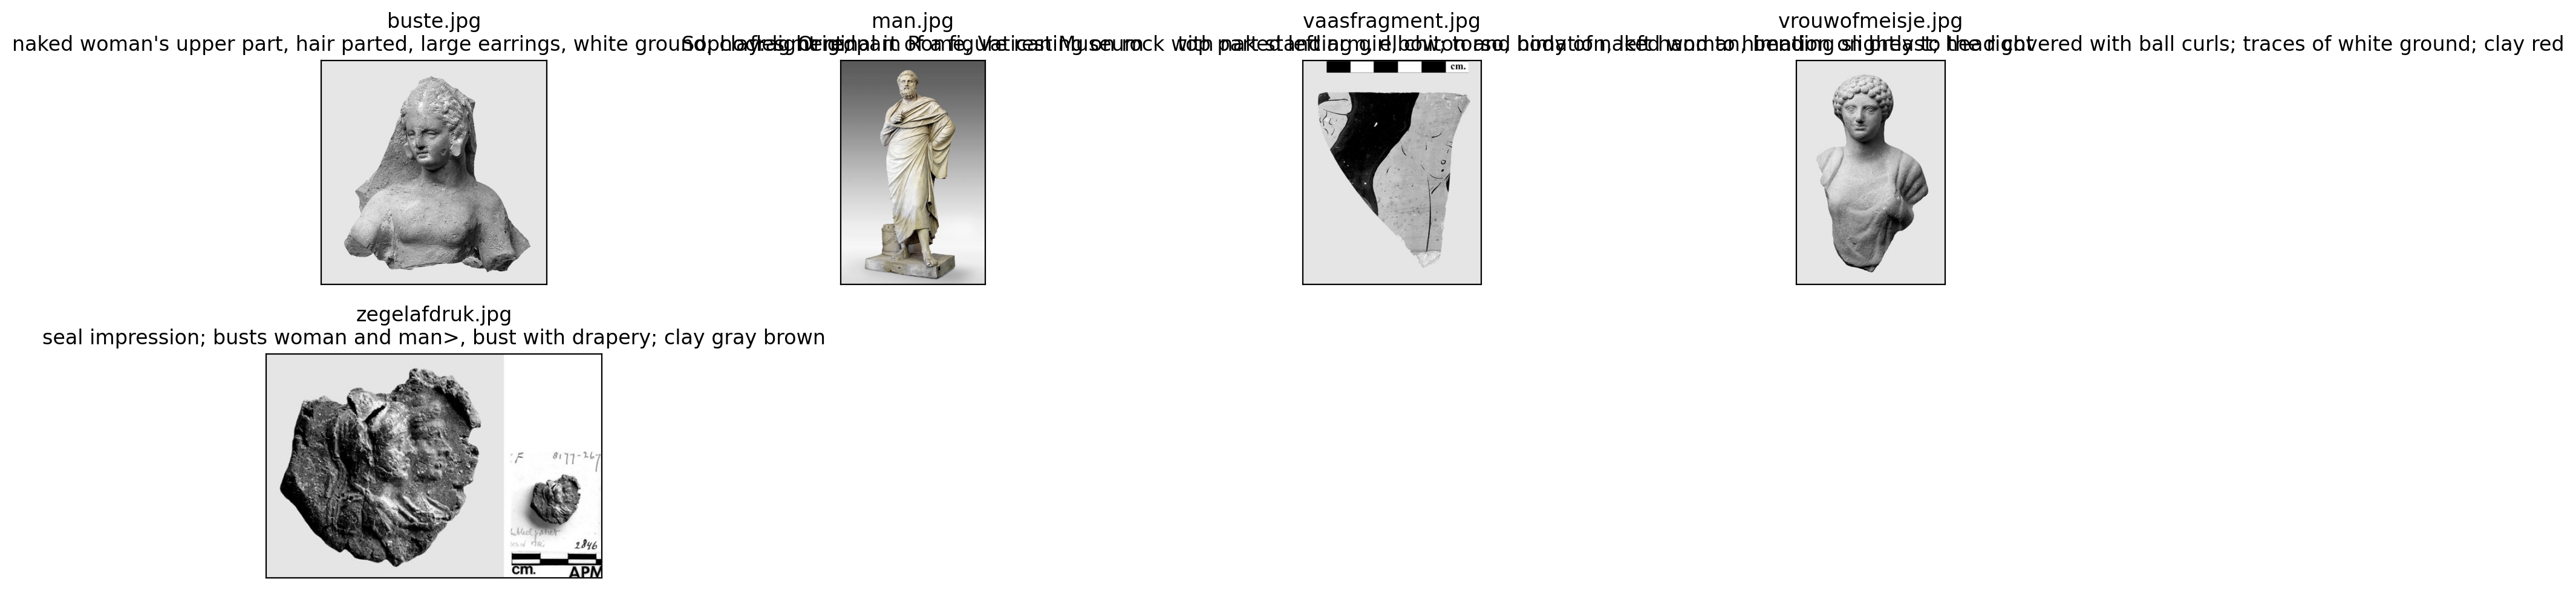

In [11]:
original_images = []
images = []
texts = []
plt.figure(figsize=(16, 5))

filepath = '../data/archobjects_sample/'

for filename in [filename for filename in os.listdir(filepath) if filename.endswith(".png") or filename.endswith(".jpg")]:
    name = os.path.splitext(filename)[0]
    if name not in descriptions:
        continue

    image = Image.open(os.path.join(filepath, filename)).convert("RGB")
  
    plt.subplot(2, 4, len(images) + 1)
    plt.imshow(image)
    plt.title(f"{filename}\n{descriptions[name]}")
    plt.xticks([])
    plt.yticks([])

    original_images.append(image)
    images.append(preprocess(image))
    texts.append(descriptions[name])

plt.tight_layout()

In [12]:
image_input = torch.tensor(np.stack(images))
text_tokens = clip.tokenize(["This is " + desc for desc in texts])

In [13]:
with torch.no_grad():
    image_features = model.encode_image(image_input).float()
    text_features = model.encode_text(text_tokens).float()

In [14]:
image_features /= image_features.norm(dim=-1, keepdim=True)
text_features /= text_features.norm(dim=-1, keepdim=True)
similarity = text_features.cpu().numpy() @ image_features.cpu().numpy().T

Text(0.5, 1.0, 'Cosine similarity between text and image features')

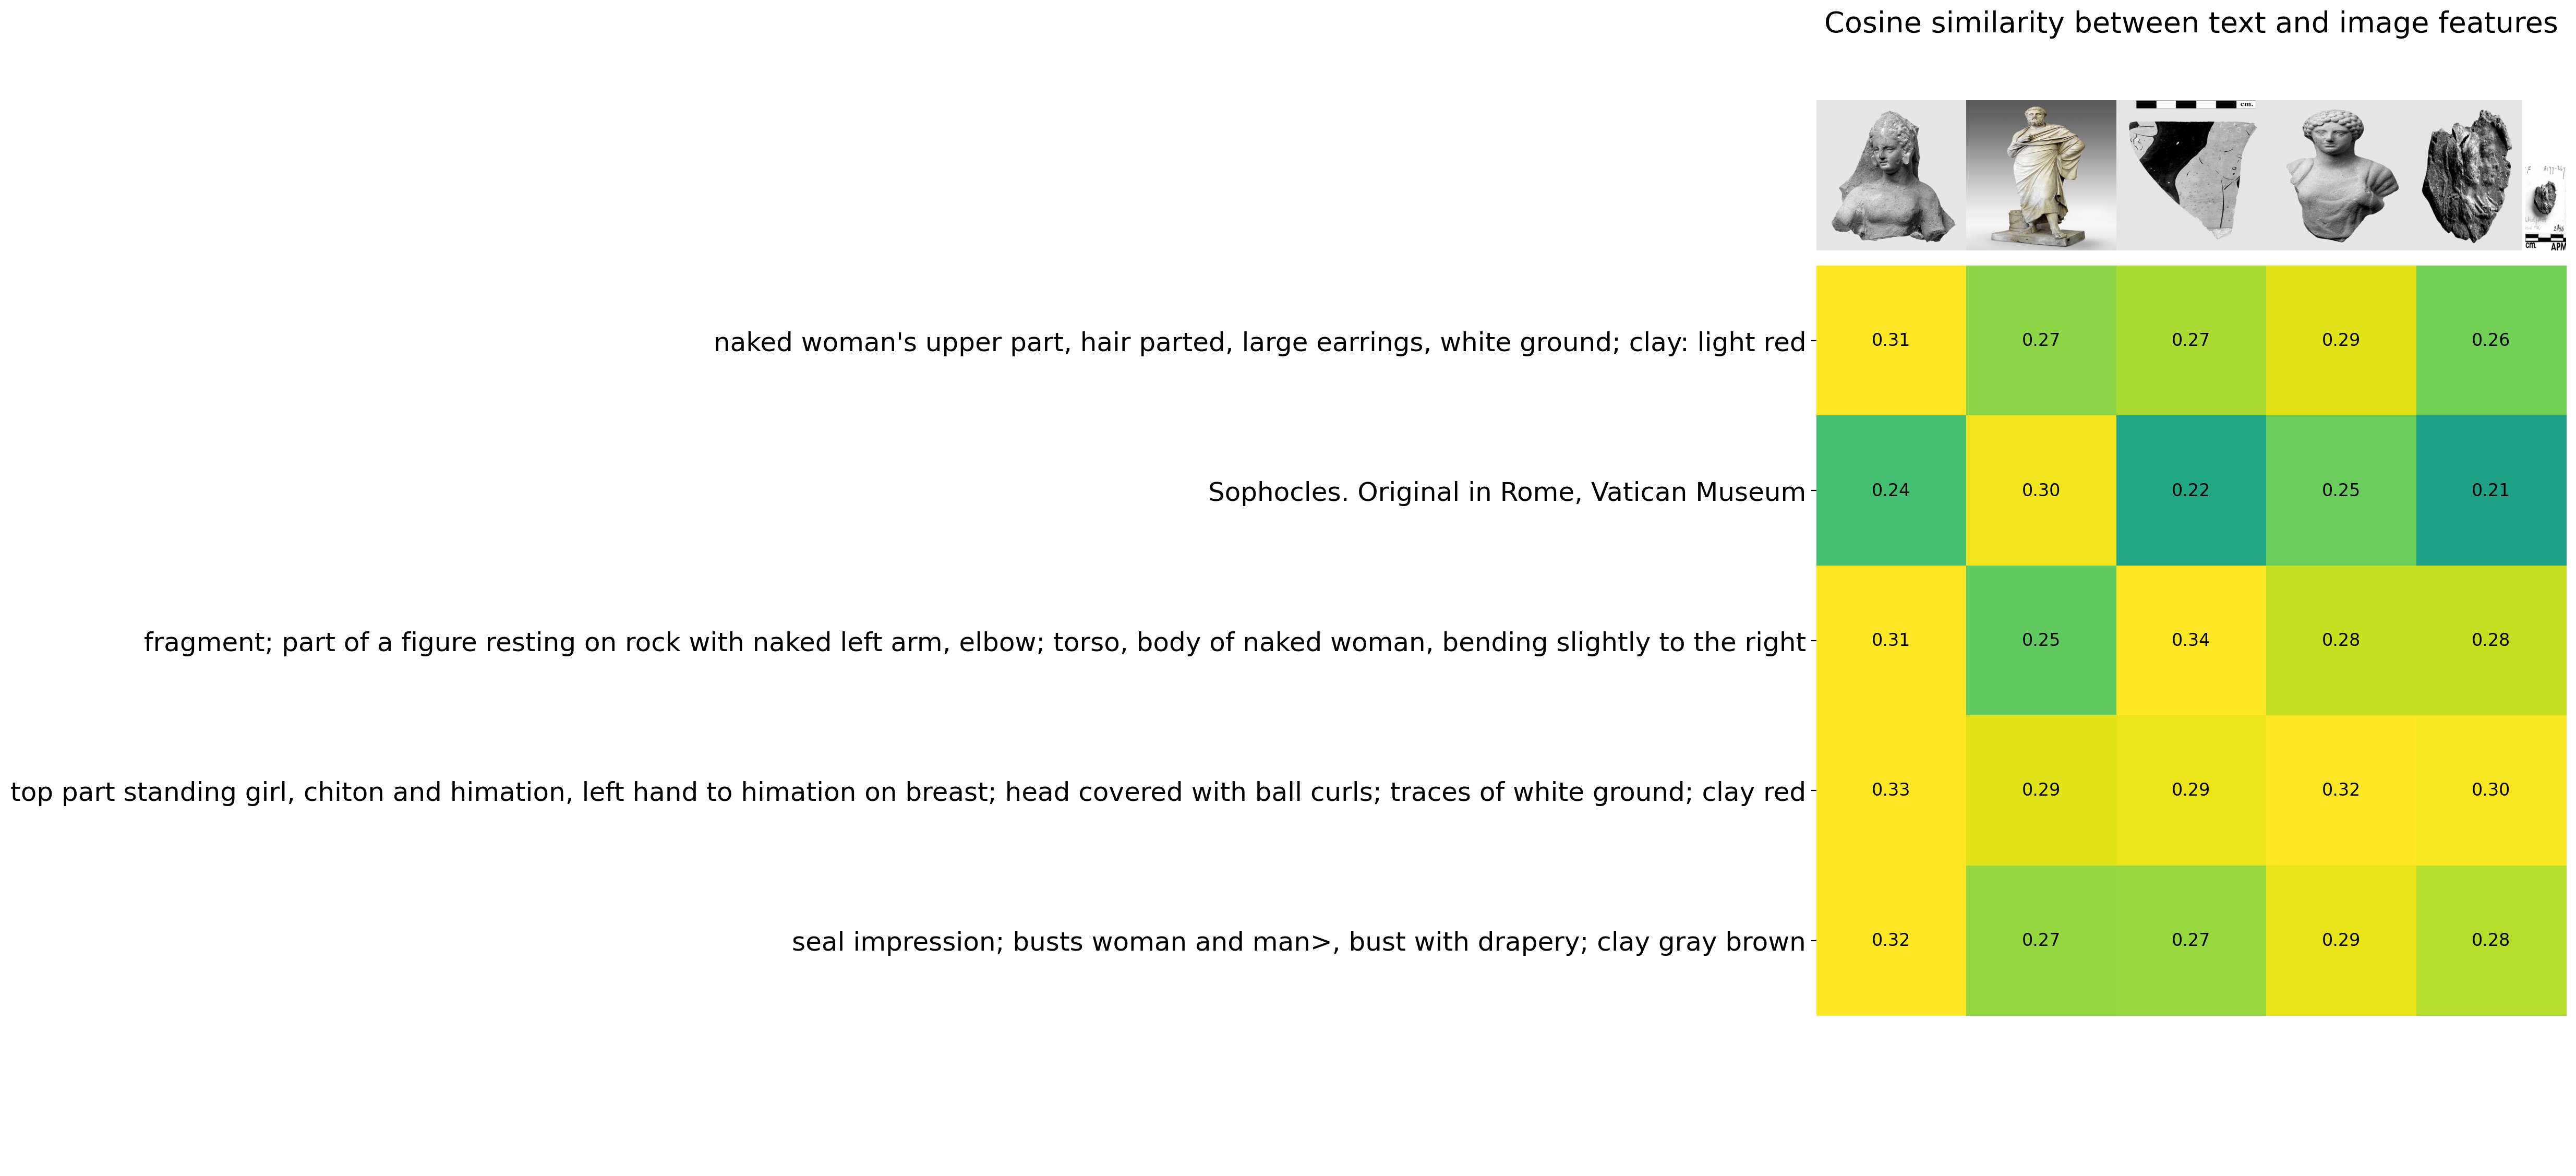

In [17]:
count = len(descriptions)

plt.figure(figsize=(20, 14))
plt.imshow(similarity, vmin=0.1, vmax=0.3)
# plt.colorbar()
plt.yticks(range(count), texts, fontsize=18)
plt.xticks([])
for i, image in enumerate(original_images):
    plt.imshow(image, extent=(i - 0.5, i + 0.5, -1.6, -0.6), origin="lower")
for x in range(similarity.shape[1]):
    for y in range(similarity.shape[0]):
        plt.text(x, y, f"{similarity[y, x]:.2f}", ha="center", va="center", size=12)

for side in ["left", "top", "right", "bottom"]:
  plt.gca().spines[side].set_visible(False)

plt.xlim([-0.5, count - 0.5])
plt.ylim([count + 0.5, -2])

plt.title("Cosine similarity between text and image features", size=20)

In [93]:
from torchvision.datasets import CIFAR100

cifar100 = CIFAR100(os.path.expanduser("~/.cache"), transform=preprocess, download=True)

100%|██████████| 169001437/169001437 [00:10<00:00, 16060704.91it/s]


Extracting /home/dariusbarsony/.cache/cifar-100-python.tar.gz to /home/dariusbarsony/.cache


In [94]:
text_descriptions = [f"This is a photo of a {label}" for label in cifar100.classes]
text_tokens = clip.tokenize(text_descriptions)

In [95]:
with torch.no_grad():
    text_features = model.encode_text(text_tokens).float()
    text_features /= text_features.norm(dim=-1, keepdim=True)

text_probs = (100.0 * image_features @ text_features.T).softmax(dim=-1)
top_probs, top_labels = text_probs.cpu().topk(5, dim=-1)

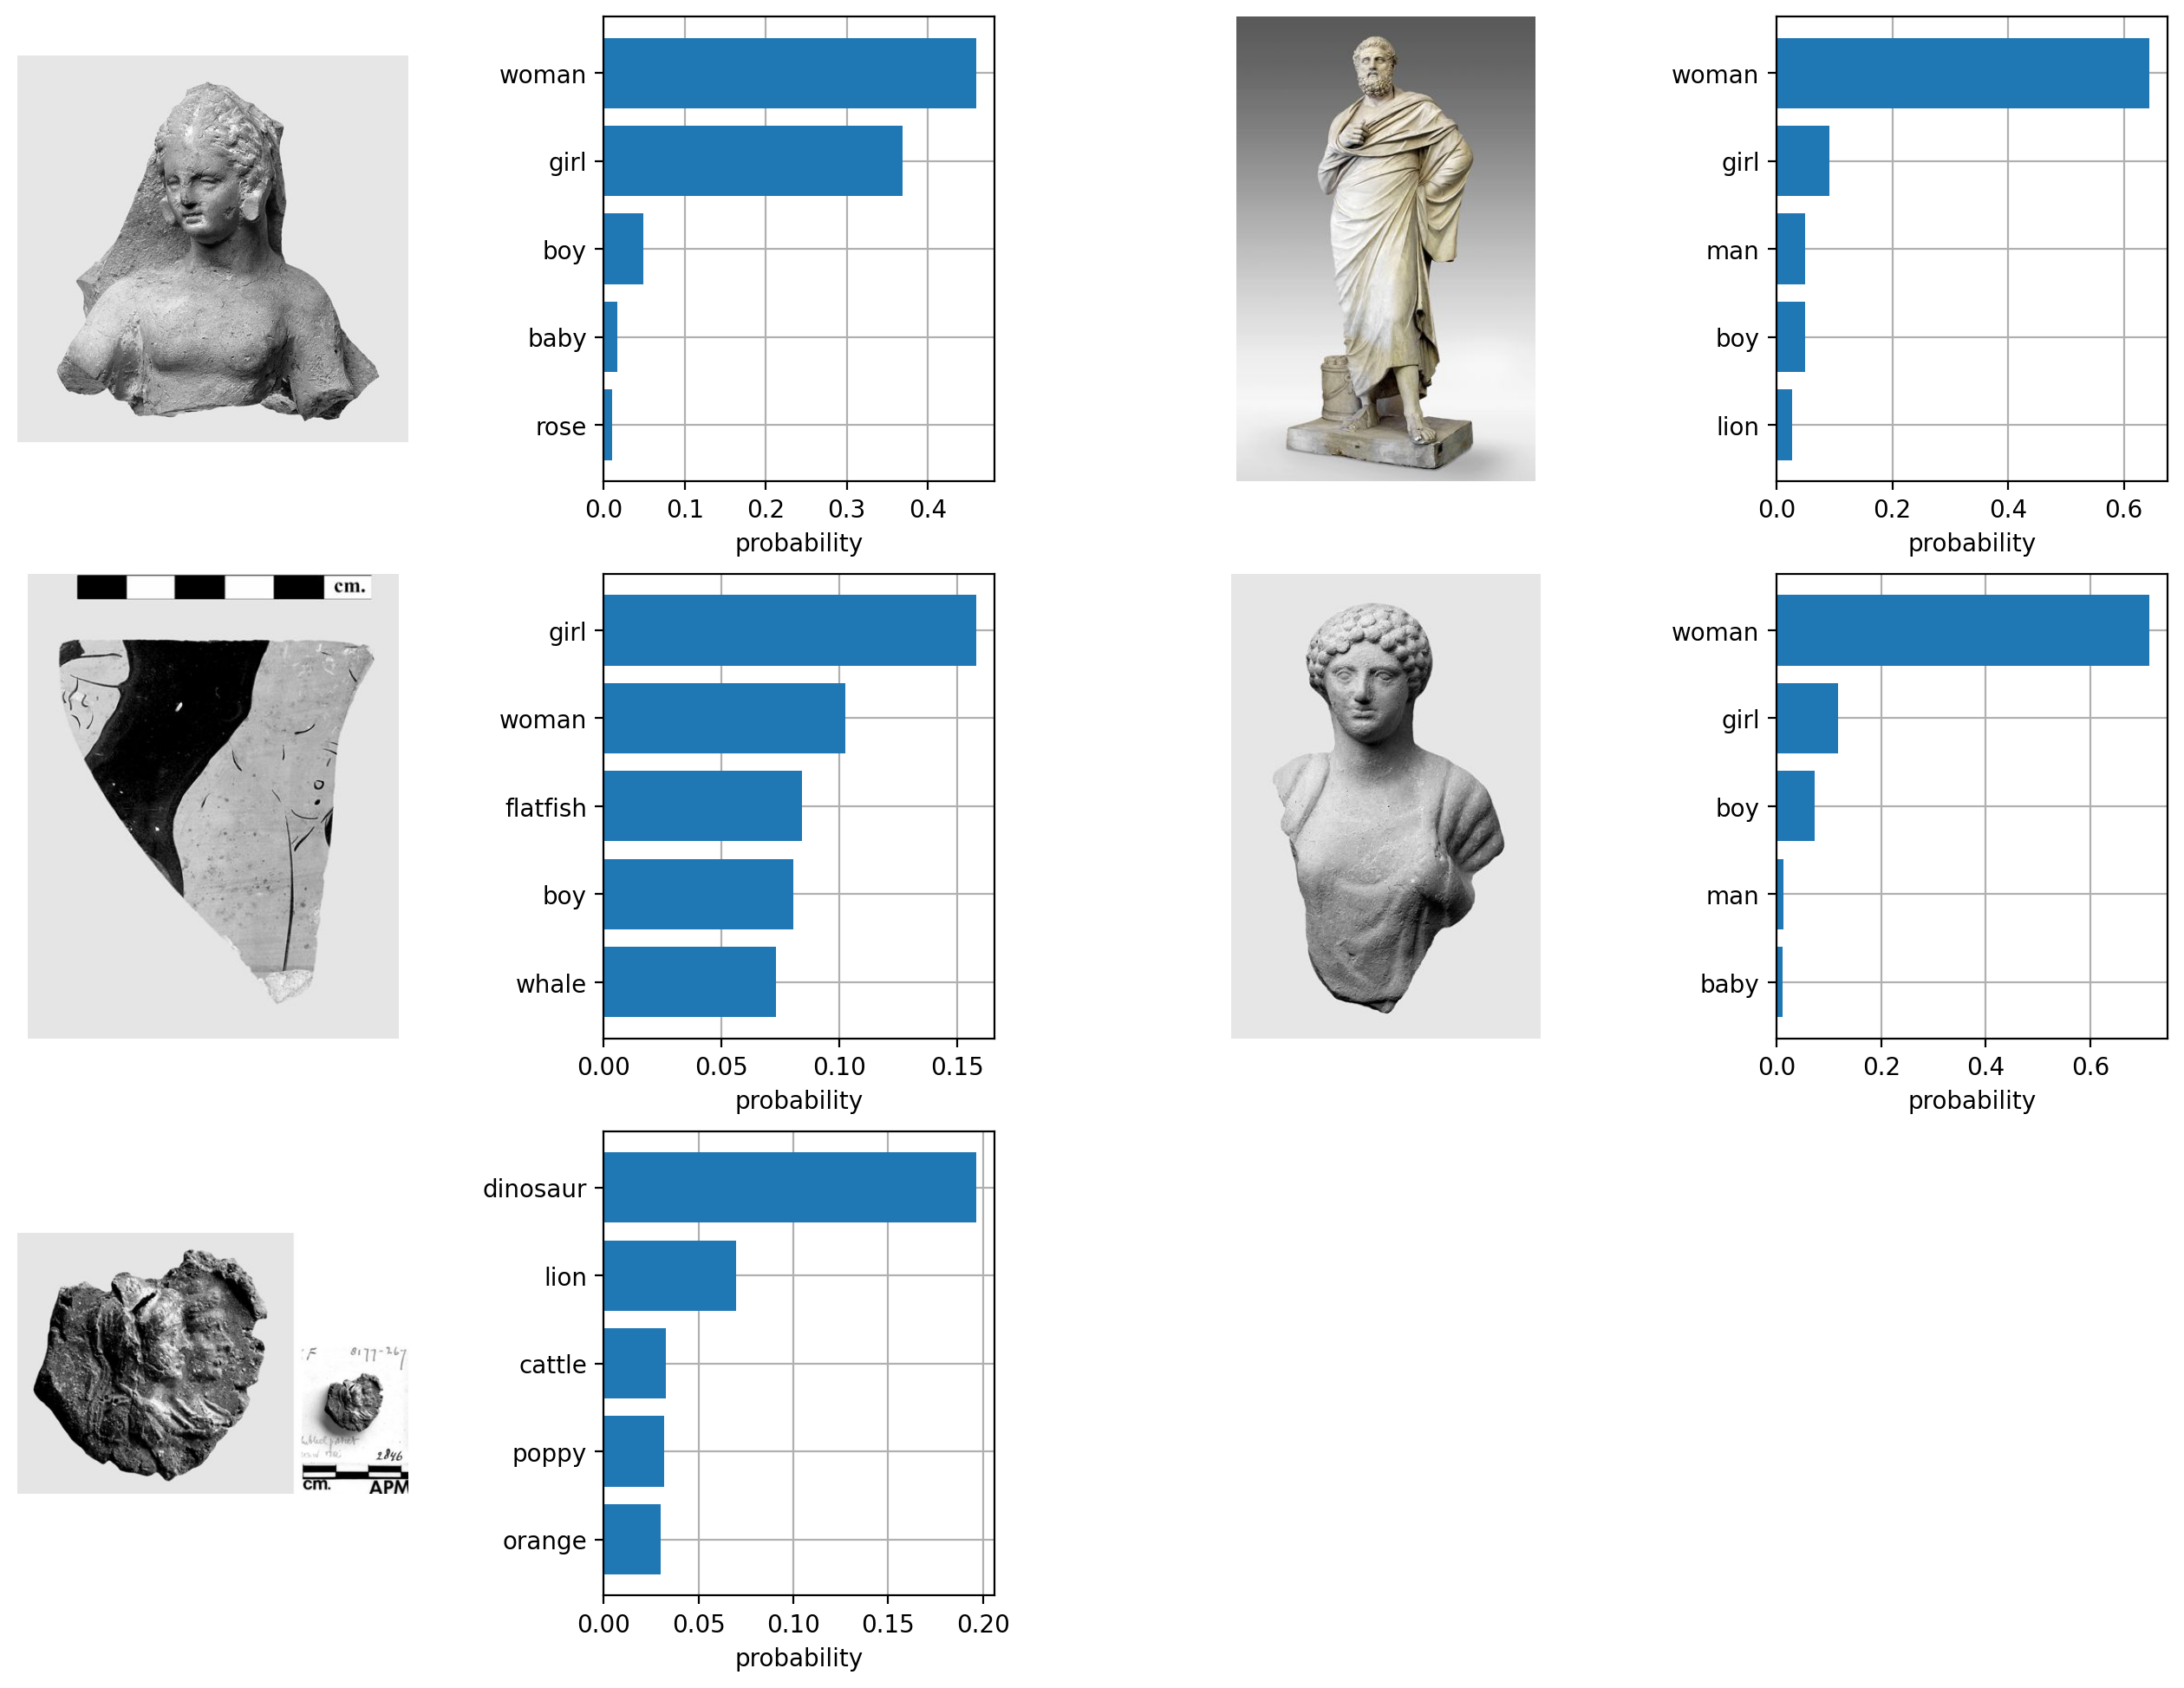

In [96]:
plt.figure(figsize=(16, 16))

for i, image in enumerate(original_images):
    plt.subplot(4, 4, 2 * i + 1)
    plt.imshow(image)
    plt.axis("off")

    plt.subplot(4, 4, 2 * i + 2)
    y = np.arange(top_probs.shape[-1])
    plt.grid()
    plt.barh(y, top_probs[i])
    plt.gca().invert_yaxis()
    plt.gca().set_axisbelow(True)
    plt.yticks(y, [cifar100.classes[index] for index in top_labels[i].numpy()])
    plt.xlabel("probability")

plt.subplots_adjust(wspace=0.5)
plt.show()